In [1]:
train_path="../input/new_dataset2/new_dataset2/new_train"
valid_path="../input/new_dataset2/new_dataset2/new_valid"
test_path="../input/new_dataset2/new_dataset2/new_test"

In [2]:
from keras.preprocessing import image
from keras.layers import Dense,Conv2D,Flatten,Dropout,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D,Activation
from keras.models import Sequential


Using TensorFlow backend.


In [3]:
train_datagen = image.ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    zoom_range=0.2,
                                    rescale=1./255,
                                    fill_mode='nearest',
                                    channel_shift_range=0.2*255)
validate_datagen  = image.ImageDataGenerator(rescale=1./255)
test_datagen  = image.ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(300,300),batch_size=32,class_mode='categorical')
valid_generator = validate_datagen.flow_from_directory(valid_path,target_size=(300,300),batch_size=32,class_mode='categorical')
test_generator= test_datagen.flow_from_directory(test_path,target_size=(300,300),batch_size=1,class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 668 images belonging to 2 classes.
Found 3642 images belonging to 2 classes.


In [5]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense ,Dropout,BatchNormalization
from keras.models import Model
from keras import regularizers


my_model = VGG16( weights= 'imagenet',
                 include_top=False )

input = Input(shape=(300,300,3),name = 'image_input')
output = my_model(input)

for layer in my_model.layers:
    layer.trainable=False

x = Flatten(name='flatten')(output)
x = Dense(4096, activation='relu', name='fc1',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', name='fc2',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='fc3',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax', name='predictions')(x)

my_model = Model(input=input, output=x)
image_size=(300,300,3)

my_model.summary()



58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 300, 300, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              169873408 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
fc2 (Dense)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [6]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
callback_list=[es,mc]

In [7]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


from keras import optimizers

my_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

history=my_model.fit_generator(train_generator,steps_per_epoch=train_generator.samples//train_generator.batch_size,epochs=30,
        validation_data = valid_generator,
        validation_steps = valid_generator.samples//valid_generator.batch_size ,
                              callbacks=callback_list )

Epoch 1/30
312/312 [==============================] - 240s 768ms/step - loss: 0.7055 - acc: 0.9532 - val_loss: 0.5143 - val_acc: 0.9828

Epoch 00001: val_acc improved from -inf to 0.98281, saving model to best_model5.h5
Epoch 2/30
312/312 [==============================] - 208s 665ms/step - loss: 0.4793 - acc: 0.9785 - val_loss: 0.6047 - val_acc: 0.8899

Epoch 00002: val_acc did not improve from 0.98281
Epoch 3/30
312/312 [==============================] - 206s 661ms/step - loss: 0.4234 - acc: 0.9788 - val_loss: 0.3689 - val_acc: 0.9843

Epoch 00003: val_acc improved from 0.98281 to 0.98428, saving model to best_model5.h5
Epoch 4/30
312/312 [==============================] - 209s 668ms/step - loss: 0.4186 - acc: 0.9770 - val_loss: 0.6247 - val_acc: 0.8994

Epoch 00004: val_acc did not improve from 0.98428
Epoch 5/30
312/312 [==============================] - 208s 667ms/step - loss: 0.3924 - acc: 0.9745 - val_loss: 0.4102 - val_acc: 0.9670

Epoch 00005: val_acc did not improve from 0.98

In [8]:
    
scores=my_model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)
print("\n%s: %.2f%%"  % (my_model.metrics_names[1],scores[1]*100) )


acc: 99.42%


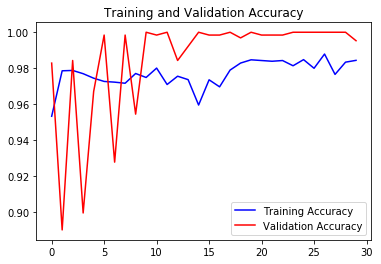

<Figure size 432x288 with 0 Axes>

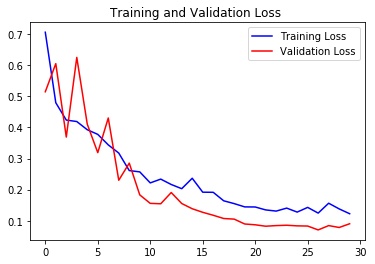

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
train_acc=history.history['acc']
val_acc=history.history['val_acc']
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs,train_loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss ')
plt.legend()
plt.figure()
plt.show()


In [10]:
import numpy as np
pred=my_model.predict_generator(test_generator,verbose=1,steps= test_generator.samples//test_generator.batch_size)
predictedClasses = np.argmax(pred, axis=1)

3642/3642 [==============================] - 41s 11ms/step


In [11]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictedClasses]

In [12]:
import pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

,Filename,Predictions
0,original/org10001.jpg,sp_noise
1,original/org10002.jpg,original
2,original/org10003.jpg,original
3,original/org10004.jpg,sp_noise
4,original/org10005.jpg,sp_noise
5,original/org10006.jpg,sp_noise
6,original/org10007.jpg,sp_noise
7,original/org10008.jpg,original
8,original/org10009.jpg,original
9,original/org10010.jpg,sp_noise


In [13]:
from sklearn import metrics
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_generator.classes, predictedClasses)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_generator.classes, predictedClasses)) 

Confusion Matrix
[[920 901]
 [916 905]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1821
           1       0.50      0.50      0.50      1821

    accuracy                           0.50      3642
   macro avg       0.50      0.50      0.50      3642
weighted avg       0.50      0.50      0.50      3642

